In [2]:
import pandas as pd
import warnings
warnings.simplefilter("ignore")
%cd '/Users/rewatsachdeva/Desktop/assesment/Arya_DataScientist_Assignment'

/Users/rewatsachdeva/Desktop/assesment/Arya_DataScientist_Assignment


In [3]:
train_benef=pd.read_csv('Medicare-Fraud-Detection-DS/train_beneficiarydata.csv')
train_labels=pd.read_csv('Medicare-Fraud-Detection-DS/train.csv')
train_ip = pd.read_csv('Medicare-Fraud-Detection-DS/train_inpatientdata.csv')
train_op=pd.read_csv('Medicare-Fraud-Detection-DS/train_outpatientdata.csv')

In [4]:
columns_to_join=train_op.columns.to_list()
train_df=pd.merge(train_op,train_ip,left_on=columns_to_join,right_on=columns_to_join,how='outer')
train_df=pd.merge(train_df,train_benef,on='BeneID',how='left')
train_df=pd.merge(train_df,train_labels,on='Provider',how='inner')
print(train_df.shape)

(558211, 55)


In [5]:
train_df.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0,inplace=True)

train_df.replace({'RenalDiseaseIndicator':'Y'},1,inplace=True)
train_df['RenalDiseaseIndicator']=train_df['RenalDiseaseIndicator'].astype(int)

In [6]:
test_benef=pd.read_csv('Medicare-Fraud-Detection-DS/test_beneficiarydata.csv')
test_labels=pd.read_csv('Medicare-Fraud-Detection-DS/test.csv')
test_ip=pd.read_csv('Medicare-Fraud-Detection-DS/test_inpatientdata.csv')
test_op=pd.read_csv('Medicare-Fraud-Detection-DS/test_outpatientdata.csv')

In [7]:
columns_to_join=test_op.columns.to_list()
test_df=pd.merge(test_op,test_ip,left_on=columns_to_join,right_on=columns_to_join,how='outer')
test_df=pd.merge(test_df,test_benef,on='BeneID',how='left')
test_df.shape

(135392, 54)

In [8]:
test_df.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0,inplace=True)

test_df.replace({'RenalDiseaseIndicator':'Y'},1,inplace=True)
test_df['RenalDiseaseIndicator']=test_df['RenalDiseaseIndicator'].astype(int)

In [9]:
def creat_feat(df):
    df['AdmissionDt']=pd.to_datetime(df['AdmissionDt'])
    df['DischargeDt']=pd.to_datetime(df['DischargeDt'])
    df['StayDuration']=df['DischargeDt']-df['AdmissionDt']
    df['StayDuration']=df['StayDuration'].dt.days

    df['ClaimStartDt'] = pd.to_datetime(df['ClaimStartDt'])
    df['ClaimEndDt'] = pd.to_datetime(df['ClaimEndDt'])
    df['ClaimDuration'] = (df['ClaimEndDt'] - df['ClaimStartDt']).dt.days

    df['DOB']=pd.to_datetime(df['DOB'])
    df['DOD']=pd.to_datetime(df['DOD'])
    max_val=max(df['DOD'].unique()[1:])
    df['DOD'].fillna(max_val, inplace=True)
    df['Age']=df['DOD']-df['DOB']
    df['Age']=df['Age'].dt.days/365

creat_feat(train_df)
creat_feat(test_df)

In [10]:
test_data_cpy=test_df
cols=test_df.columns
test_df=pd.concat([test_df,train_df[cols]],axis=0)
test_df.shape

(693603, 57)

In [11]:
def grp_by_col(df,col,pre):
    df[pre+"ClmAmtReimb"]=df.groupby(col)['InscClaimAmtReimbursed'].transform('mean')
    df[pre+"DeducAmtPaid"]=df.groupby(col)['DeductibleAmtPaid'].transform('mean')
    df[pre+"IPReimbAmt"]=df.groupby(col)['IPAnnualReimbursementAmt'].transform('mean')
    df[pre+"IPDeducAmt"]=df.groupby(col)['IPAnnualDeductibleAmt'].transform('mean')
    df[pre+"OPReimbAmt"]=df.groupby(col)['OPAnnualReimbursementAmt'].transform('mean')
    df[pre+"OPDeducAmt"]=df.groupby(col)['OPAnnualDeductibleAmt'].transform('mean')
    df[pre+"NoOfMonths_PartACov"]=df.groupby(col)['NoOfMonths_PartACov'].transform('mean')
    df[pre+"NoOfMonths_PartBCov"]=df.groupby(col)['NoOfMonths_PartBCov'].transform('mean')
    df[pre+"Stay"]=df.groupby(col)['StayDuration'].transform('mean')
    df[pre+"ClmDur"]=df.groupby(col)['ClaimDuration'].transform('mean')
    df[pre+'Age']=df.groupby(col)['Age'].transform('mean')

grp_by_col(train_df,'Provider','Prov')
grp_by_col(test_df,'Provider','Prov')

grp_by_col(train_df,'BeneID','BeneID')
grp_by_col(test_df,'BeneID','BeneID')

grp_by_col(train_df,'OtherPhysician','OthPhy')
grp_by_col(test_df,'OtherPhysician','OthPhy')

grp_by_col(train_df,'OperatingPhysician','OperPhy')
grp_by_col(test_df,'OperatingPhysician','OperPhy')

grp_by_col(train_df,'AttendingPhysician','AttPhy')
grp_by_col(test_df,'AttendingPhysician','AttPhy')

grp_by_col(train_df,'DiagnosisGroupCode','DiagCode')
grp_by_col(test_df,'DiagnosisGroupCode','DiagCode')

grp_by_col(train_df,'ClmAdmitDiagnosisCode','ClmAdCode')
grp_by_col(test_df,'ClmAdmitDiagnosisCode','ClmAdCode')

print(train_df.shape)
print(test_df.shape)

(558211, 135)
(693603, 134)


In [12]:
#train data
train_df['ProvTotClm']=train_df.groupby(['Provider'])['ClaimID'].transform('count')
train_df['PrvTotAdmitDCodes'] = train_df.groupby(['Provider'])['ClmAdmitDiagnosisCode'].transform('count')
train_df['PrvTotDGrpCodes'] = train_df.groupby(['Provider'])['DiagnosisGroupCode'].transform('count')
train_df['AttPhyTotCl'] = train_df.groupby(['AttendingPhysician'])['ClaimID'].transform('count')
train_df['OpPhyTotCl'] = train_df.groupby(['OperatingPhysician'])['ClaimID'].transform('count')
train_df['OthPhyTotCl'] = train_df.groupby(['OtherPhysician'])['ClaimID'].transform('count')

#test data
test_df['PrvTotAdmitDCodes'] = test_df.groupby(['Provider'])['ClmAdmitDiagnosisCode'].transform('nunique')
test_df['PrvTotDGrpCodes'] = test_df.groupby(['Provider'])['DiagnosisGroupCode'].transform('nunique')
test_df['ProvTotClm']=test_df.groupby(['Provider'])['ClaimID'].transform('count')
test_df['AttPhyTotCl'] = test_df.groupby(['AttendingPhysician'])['ClaimID'].transform('count')
test_df['OpPhyTotCl'] = test_df.groupby(['OperatingPhysician'])['ClaimID'].transform('count')
test_df['OthPhyTotCl'] = test_df.groupby(['OtherPhysician'])['ClaimID'].transform('count')

print(train_df.shape)
print(test_df.shape)

(558211, 141)
(693603, 140)


In [13]:
#train data
train_df['ProvClmAdCode']=train_df.groupby(['Provider','ClmAdmitDiagnosisCode'])['ClaimID'].transform('count')
train_df['ProvDGCode']=train_df.groupby(['Provider','DiagnosisGroupCode'])['ClaimID'].transform('count')

train_df['ProvClmDCode_1']=train_df.groupby(['Provider','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_df['ProvClmDCode_2']=train_df.groupby(['Provider','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
train_df['ProvClmDCode_3']=train_df.groupby(['Provider','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
train_df['ProvClmDCode_4']=train_df.groupby(['Provider','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
train_df['ProvClmDCode_5']=train_df.groupby(['Provider','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
train_df['ProvClmDCode_6']=train_df.groupby(['Provider','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
train_df['ProvClmDCode_7']=train_df.groupby(['Provider','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
train_df['ProvClmDCode_8']=train_df.groupby(['Provider','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
train_df['ProvClmDCode_9']=train_df.groupby(['Provider','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
train_df['ProvClmDCode_10']=train_df.groupby(['Provider','ClmDiagnosisCode_10'])['ClaimID'].transform('count')


train_df['ProvClmPCode_1']=train_df.groupby(['Provider','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_df['ProvClmPCode_2']=train_df.groupby(['Provider','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_df['ProvClmPCode_3']=train_df.groupby(['Provider','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_df['ProvClmPCode_4']=train_df.groupby(['Provider','ClmProcedureCode_4'])['ClaimID'].transform('count')
train_df['ProvClmPCode_5']=train_df.groupby(['Provider','ClmProcedureCode_5'])['ClaimID'].transform('count')

train_df['ProvBen']=train_df.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
train_df['ProvOpPhy']=train_df.groupby(['Provider','OperatingPhysician'])['ClaimID'].transform('count')
train_df['ProvOthPhy']=train_df.groupby(['Provider','OtherPhysician'])['ClaimID'].transform('count')
train_df['ProvAttPhy']=train_df.groupby(['Provider','AttendingPhysician'])['ClaimID'].transform('count')
train_df['ProvTottPhy']=train_df['ProvBen']+train_df['ProvOpPhy']+train_df['ProvOthPhy']

#test data
test_df['ProvClmAdCode']=test_df.groupby(['Provider','ClmAdmitDiagnosisCode'])['ClaimID'].transform('count')
test_df['ProvDGCode']=test_df.groupby(['Provider','DiagnosisGroupCode'])['ClaimID'].transform('count')

test_df['ProvClmDCode_1']=test_df.groupby(['Provider','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
test_df['ProvClmDCode_2']=test_df.groupby(['Provider','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
test_df['ProvClmDCode_3']=test_df.groupby(['Provider','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
test_df['ProvClmDCode_4']=test_df.groupby(['Provider','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
test_df['ProvClmDCode_5']=test_df.groupby(['Provider','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
test_df['ProvClmDCode_6']=test_df.groupby(['Provider','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
test_df['ProvClmDCode_7']=test_df.groupby(['Provider','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
test_df['ProvClmDCode_8']=test_df.groupby(['Provider','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
test_df['ProvClmDCode_9']=test_df.groupby(['Provider','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
test_df['ProvClmDCode_10']=test_df.groupby(['Provider','ClmDiagnosisCode_10'])['ClaimID'].transform('count')

test_df['ProvClmPCode_1']=test_df.groupby(['Provider','ClmProcedureCode_1'])['ClaimID'].transform('count')
test_df['ProvClmPCode_2']=test_df.groupby(['Provider','ClmProcedureCode_2'])['ClaimID'].transform('count')
test_df['ProvClmPCode_3']=test_df.groupby(['Provider','ClmProcedureCode_3'])['ClaimID'].transform('count')
test_df['ProvClmPCode_4']=test_df.groupby(['Provider','ClmProcedureCode_4'])['ClaimID'].transform('count')
test_df['ProvClmPCode_5']=test_df.groupby(['Provider','ClmProcedureCode_5'])['ClaimID'].transform('count')

test_df['ProvBen']=test_df.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
test_df['ProvOpPhy']=test_df.groupby(['Provider','OperatingPhysician'])['ClaimID'].transform('count')
test_df['ProvOthPhy']=test_df.groupby(['Provider','OtherPhysician'])['ClaimID'].transform('count')
test_df['ProvAttPhy']=test_df.groupby(['Provider','AttendingPhysician'])['ClaimID'].transform('count')
test_df['ProvTottPhy']=test_df['ProvBen']+test_df['ProvOpPhy']+test_df['ProvOthPhy']


print(train_df.shape)
print(test_df.shape)

(558211, 163)
(693603, 162)


In [14]:
#train data
train_df['ProvBenAttPhy']=train_df.groupby(['Provider','BeneID','AttendingPhysician'])['ClaimID'].transform('count')
train_df['ProvBenOpPhy']=train_df.groupby(['Provider','BeneID','OperatingPhysician'])['ClaimID'].transform('count')
train_df['ProvBenOthPhy']=train_df.groupby(['Provider','BeneID','OtherPhysician'])['ClaimID'].transform('count')

train_df["ProvBeneIDClmPCode_1"]=train_df.groupby(['Provider','BeneID','ClmProcedureCode_1'])['ClaimID'].transform('count')
train_df["ProvBeneIDClmPCode_2"]=train_df.groupby(['Provider','BeneID','ClmProcedureCode_2'])['ClaimID'].transform('count')
train_df["ProvBeneIDClmPCode_3"]=train_df.groupby(['Provider','BeneID','ClmProcedureCode_3'])['ClaimID'].transform('count')
train_df["ProvBeneIDClmPCode_4"]=train_df.groupby(['Provider','BeneID','ClmProcedureCode_4'])['ClaimID'].transform('count')
train_df["ProvBeneIDClmPCode_5"]=train_df.groupby(['Provider','BeneID','ClmProcedureCode_5'])['ClaimID'].transform('count')

train_df["ProvBeneIDClmDCode_1"]=train_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
train_df["ProvBeneIDClmDCode_2"]=train_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
train_df["ProvBeneIDClmDCode_3"]=train_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
train_df["ProvBeneIDClmDCode_4"]=train_df.groupby(['Provider','BeneID','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
train_df["ProvBeneIDClmDCode_5"]=train_df.groupby(['Provider','BeneID','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
train_df["ProvBeneIDClmDCode_6"]=train_df.groupby(['Provider','BeneID','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
train_df["ProvBeneIDClmDCode_7"]=train_df.groupby(['Provider','BeneID','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
train_df["ProvBeneIDClmDCode_8"]=train_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
train_df["ProvBeneIDClmDCode_9"]=train_df.groupby(['Provider','BeneID','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
train_df["ProvBeneIDClmDCode10"]=train_df.groupby(['Provider','BeneID','ClmDiagnosisCode_10'])['ClaimID'].transform('count')


#test data
test_df['ProvBenAttPhy']=test_df.groupby(['Provider','BeneID','AttendingPhysician'])['ClaimID'].transform('count')
test_df['ProvBenOpPhy']=test_df.groupby(['Provider','BeneID','OperatingPhysician'])['ClaimID'].transform('count')
test_df['ProvBenOthPhy']=test_df.groupby(['Provider','BeneID','OtherPhysician'])['ClaimID'].transform('count')

test_df["ProvBeneIDClmPCode_1"]=test_df.groupby(['Provider','BeneID','ClmProcedureCode_1'])['ClaimID'].transform('count')
test_df["ProvBeneIDClmPCode_2"]=test_df.groupby(['Provider','BeneID','ClmProcedureCode_2'])['ClaimID'].transform('count')
test_df["ProvBeneIDClmPCode_3"]=test_df.groupby(['Provider','BeneID','ClmProcedureCode_3'])['ClaimID'].transform('count')
test_df["ProvBeneIDClmPCode_4"]=test_df.groupby(['Provider','BeneID','ClmProcedureCode_4'])['ClaimID'].transform('count')
test_df["ProvBeneIDClmPCode_5"]=test_df.groupby(['Provider','BeneID','ClmProcedureCode_5'])['ClaimID'].transform('count')

test_df["ProvBeneIDClmDCode_1"]=test_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
test_df["ProvBeneIDClmDCode_2"]=test_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
test_df["ProvBeneIDClmDCode_3"]=test_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
test_df["ProvBeneIDClmDCode_4"]=test_df.groupby(['Provider','BeneID','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
test_df["ProvBeneIDClmDCode_5"]=test_df.groupby(['Provider','BeneID','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
test_df["ProvBeneIDClmDCode_6"]=test_df.groupby(['Provider','BeneID','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
test_df["ProvBeneIDClmDCode_7"]=test_df.groupby(['Provider','BeneID','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
test_df["ProvBeneIDClmDCode_8"]=test_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
test_df["ProvBeneIDClmDCode_9"]=test_df.groupby(['Provider','BeneID','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
test_df["ProvBeneIDClmDCode_10"]=test_df.groupby(['Provider','BeneID','ClmDiagnosisCode_10'])['ClaimID'].transform('count')

print(train_df.shape)
print(test_df.shape)

(558211, 181)
(693603, 180)


In [15]:
def grp(df):
    df["ProvBeneIDAttPhysClmPCode_1"]=df.groupby(['Provider','BeneID','AttendingPhysician',
                                                            'ClmProcedureCode_1'])['ClaimID'].transform('count')
    df["ProvBeneIDAttPhysClmPCode_2"]=df.groupby(['Provider','BeneID','AttendingPhysician',
                                                            'ClmProcedureCode_2'])['ClaimID'].transform('count')
    df["ProvBeneIDAttPhysClmPCode_3"]=df.groupby(['Provider','BeneID','AttendingPhysician',
                                                            'ClmProcedureCode_3'])['ClaimID'].transform('count')
    df["ProvBeneIDAttPhysClmPCode_4"]=df.groupby(['Provider','BeneID','AttendingPhysician',
                                                            'ClmProcedureCode_4'])['ClaimID'].transform('count')
    df["ProvBeneIDAttPhysClmPCode_5"]=df.groupby(['Provider','BeneID','AttendingPhysician',
                                                            'ClmProcedureCode_5'])['ClaimID'].transform('count')

    df["ProvBeneIDOpPhyClmPCode_1"]=df.groupby(['Provider','BeneID','OperatingPhysician',
                                                            'ClmProcedureCode_1'])['ClaimID'].transform('count')
    df["ProvBeneIDOpPhyClmPCode_2"]=df.groupby(['Provider','BeneID','OperatingPhysician',
                                                            'ClmProcedureCode_2'])['ClaimID'].transform('count')
    df["ProvBeneIDOpPhyClmPCode_3"]=df.groupby(['Provider','BeneID','OperatingPhysician',
                                                            'ClmProcedureCode_3'])['ClaimID'].transform('count')
    df["ProvBeneIDOpPhyClmPCode_4"]=df.groupby(['Provider','BeneID','OperatingPhysician',
                                                            'ClmProcedureCode_4'])['ClaimID'].transform('count')
    df["ProvBeneIDOpPhyClmPCode_5"]=df.groupby(['Provider','BeneID','OperatingPhysician',
                                                            'ClmProcedureCode_5'])['ClaimID'].transform('count')

    df["ProvBeneIDOthPhyClmPCode_1"]=df.groupby(['Provider','BeneID','OtherPhysician',
                                                            'ClmProcedureCode_1'])['ClaimID'].transform('count')
    df["ProvBeneIDOthPhyClmPCode_2"]=df.groupby(['Provider','BeneID','OtherPhysician',
                                                            'ClmProcedureCode_2'])['ClaimID'].transform('count')
    df["ProvBeneIDOthPhyClmPCode_3"]=df.groupby(['Provider','BeneID','OtherPhysician',
                                                            'ClmProcedureCode_3'])['ClaimID'].transform('count')
    df["ProvBeneIDOthPhyClmPCode_4"]=df.groupby(['Provider','BeneID','OtherPhysician',
                                                            'ClmProcedureCode_4'])['ClaimID'].transform('count')
    df["ProvBeneIDOthPhyClmPCode_5"]=df.groupby(['Provider','BeneID','OtherPhysician',
                                                            'ClmProcedureCode_5'])['ClaimID'].transform('count')
    
    df["ProvBeneIDAttPhyClmDCode_1"]=df.groupby(['Provider','BeneID','AttendingPhysician',
                                                            'ClmDiagnosisCode_1'])['ClaimID'].transform('count')
    df["ProvBeneIDAttPhyClmDCode_2"]=df.groupby(['Provider','BeneID','AttendingPhysician',
                                                            'ClmDiagnosisCode_2'])['ClaimID'].transform('count')
    df["ProvBeneIDAttPhyClmDCode_3"]=df.groupby(['Provider','BeneID','AttendingPhysician',
                                                            'ClmDiagnosisCode_3'])['ClaimID'].transform('count')
    df["ProvBeneIDAttPhyClmDCode_4"]=df.groupby(['Provider','BeneID','AttendingPhysician',
                                                            'ClmDiagnosisCode_4'])['ClaimID'].transform('count')
    df["ProvBeneIDAttPhyClmDCode_5"]=df.groupby(['Provider','BeneID','AttendingPhysician',
                                                            'ClmDiagnosisCode_5'])['ClaimID'].transform('count')
    df["ProvBeneIDAttPhyClmDCode_6"]=df.groupby(['Provider','BeneID','AttendingPhysician',
                                                            'ClmDiagnosisCode_6'])['ClaimID'].transform('count')
    df["ProvBeneIDAttPhyClmDCode_7"]=df.groupby(['Provider','BeneID','AttendingPhysician',
                                                            'ClmDiagnosisCode_7'])['ClaimID'].transform('count')
    df["ProvBeneIDAttPhyClmDCode_8"]=df.groupby(['Provider','BeneID','AttendingPhysician',
                                                            'ClmDiagnosisCode_8'])['ClaimID'].transform('count')
    df["ProvBeneIDAttPhyClmDCode_9"]=df.groupby(['Provider','BeneID','AttendingPhysician',
                                                            'ClmDiagnosisCode_9'])['ClaimID'].transform('count')
    df["ProvBeneIDAttPhyClmDCode_10"]=df.groupby(['Provider','BeneID','AttendingPhysician',
                                                            'ClmDiagnosisCode_10'])['ClaimID'].transform('count')
    

    df["ProvBeneIDOpPhyClmDCode_1"]=df.groupby(['Provider','BeneID','OperatingPhysician',
                                                            'ClmDiagnosisCode_1'])['ClaimID'].transform('count')
    df["ProvBeneIDOpPhyClmDCode_2"]=df.groupby(['Provider','BeneID','OperatingPhysician',
                                                            'ClmDiagnosisCode_2'])['ClaimID'].transform('count')
    df["ProvBeneIDOpPhyClmDCode_3"]=df.groupby(['Provider','BeneID','OperatingPhysician',
                                                            'ClmDiagnosisCode_3'])['ClaimID'].transform('count')
    df["ProvBeneIDOpPhyClmDCode_4"]=df.groupby(['Provider','BeneID','OperatingPhysician',
                                                            'ClmDiagnosisCode_4'])['ClaimID'].transform('count')
    df["ProvBeneIDOpPhyClmDCode_5"]=df.groupby(['Provider','BeneID','OperatingPhysician',
                                                            'ClmDiagnosisCode_5'])['ClaimID'].transform('count')
    df["ProvBeneIDOpPhyClmDCode_6"]=df.groupby(['Provider','BeneID','OperatingPhysician',
                                                            'ClmDiagnosisCode_6'])['ClaimID'].transform('count')
    df["ProvBeneIDOpPhyClmDCode_7"]=df.groupby(['Provider','BeneID','OperatingPhysician',
                                                            'ClmDiagnosisCode_7'])['ClaimID'].transform('count')
    df["ProvBeneIDOpPhyClmDCode_8"]=df.groupby(['Provider','BeneID','OperatingPhysician',
                                                            'ClmDiagnosisCode_8'])['ClaimID'].transform('count')
    df["ProvBeneIDOpPhyClmDCode_9"]=df.groupby(['Provider','BeneID','OperatingPhysician',
                                                            'ClmDiagnosisCode_9'])['ClaimID'].transform('count')
    df["ProvBeneIDOpPhyClmDCode_10"]=df.groupby(['Provider','BeneID','OperatingPhysician',
                                                            'ClmDiagnosisCode_10'])['ClaimID'].transform('count')
    
    
    df["ProvBeneIDOthPhyClmDCode_1"]=df.groupby(['Provider','BeneID','OtherPhysician',
                                                            'ClmDiagnosisCode_1'])['ClaimID'].transform('count')
    df["ProvBeneIDOthPhyClmDCode_2"]=df.groupby(['Provider','BeneID','OtherPhysician',
                                                            'ClmDiagnosisCode_2'])['ClaimID'].transform('count')
    df["ProvBeneIDOthPhyClmDCode_3"]=df.groupby(['Provider','BeneID','OtherPhysician',
                                                            'ClmDiagnosisCode_3'])['ClaimID'].transform('count')
    df["ProvBeneIDOthPhyClmDCode_4"]=df.groupby(['Provider','BeneID','OtherPhysician',
                                                            'ClmDiagnosisCode_4'])['ClaimID'].transform('count')
    df["ProvBeneIDOthPhyClmDCode_5"]=df.groupby(['Provider','BeneID','OtherPhysician',
                                                            'ClmDiagnosisCode_5'])['ClaimID'].transform('count')
    df["ProvBeneIDOthPhyClmDCode_6"]=df.groupby(['Provider','BeneID','OtherPhysician',
                                                            'ClmDiagnosisCode_6'])['ClaimID'].transform('count')
    df["ProvBeneIDOthPhyClmDCode_7"]=df.groupby(['Provider','BeneID','OtherPhysician',
                                                            'ClmDiagnosisCode_7'])['ClaimID'].transform('count')
    df["ProvBeneIDOthPhyClmDCode_8"]=df.groupby(['Provider','BeneID','OtherPhysician',
                                                            'ClmDiagnosisCode_8'])['ClaimID'].transform('count')
    df["ProvBeneIDOthPhyClmDCode_9"]=df.groupby(['Provider','BeneID','OtherPhysician',
                                                            'ClmDiagnosisCode_9'])['ClaimID'].transform('count')
    df["ProvBeneIDOthPhyClmDCode_10"]=df.groupby(['Provider','BeneID','OtherPhysician',
                                                            'ClmDiagnosisCode_10'])['ClaimID'].transform('count')

grp(train_df)
grp(test_df)

print(train_df.shape)
print(test_df.shape)

(558211, 226)
(693603, 225)


In [16]:
test_df=test_df.iloc[:len(test_data_cpy),:]
print(test_df.shape)

(135392, 225)


In [17]:
drop_cols=['BeneID','ClaimID','ClaimStartDt','ClaimEndDt','AttendingPhysician','OperatingPhysician','OtherPhysician',
          'AdmissionDt','ClmAdmitDiagnosisCode','DischargeDt','DiagnosisGroupCode','ClmDiagnosisCode_1','ClmDiagnosisCode_2', 
          'ClmDiagnosisCode_3','ClmDiagnosisCode_4','ClmDiagnosisCode_5','ClmDiagnosisCode_6','ClmDiagnosisCode_7', 
          'ClmDiagnosisCode_8','ClmDiagnosisCode_9','ClmDiagnosisCode_10','ClmProcedureCode_1','ClmProcedureCode_2', 
          'ClmProcedureCode_3','ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6',
          'DOB','DOD','County','State']

train=train_df.drop(columns=drop_cols,errors='ignore')
train['RenalDiseaseIndicator']=train['RenalDiseaseIndicator'].astype(int)
test=test_df.drop(columns=drop_cols,errors='ignore')
test['RenalDiseaseIndicator']=test['RenalDiseaseIndicator'].astype(int)

train.fillna(0,inplace=True)
test.fillna(0,inplace=True)

In [18]:
train=train.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')
test=test.groupby(['Provider'],as_index=False).agg('sum')
print(train.shape)
print(test.shape)

(5410, 195)
(1353, 194)


In [19]:
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,StandardScaler
from sklearn.model_selection import train_test_split

y=train['PotentialFraud'].to_numpy()
x=train.drop(['PotentialFraud','Provider'], axis=1).to_numpy()
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.25,random_state=1)
t_encoder=LabelEncoder()
scaler=StandardScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_val=scaler.transform(x_val)
y_train=t_encoder.fit_transform(y_train)
y_val=t_encoder.transform(y_val)
X_test=test.drop(columns='Provider').to_numpy()
X_test=scaler.transform(X_test)

In [20]:
from imblearn.over_sampling import ADASYN,SMOTE

# oversample=ADASYN(n_neighbors=8,n_jobs=4)
oversample=SMOTE(k_neighbors=12,n_jobs=4,random_state=1)
x_over,y_over=oversample.fit_resample(x_train, y_train)

x_over.shape,y_over.shape

((7342, 193), (7342,))

In [21]:
from collections import Counter
Counter(y_over)

Counter({0: 3671, 1: 3671})

In [22]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()

In [23]:
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix,balanced_accuracy_score,accuracy_score
model.fit(x_over,y_over)
y_pred=model.predict(x_val)

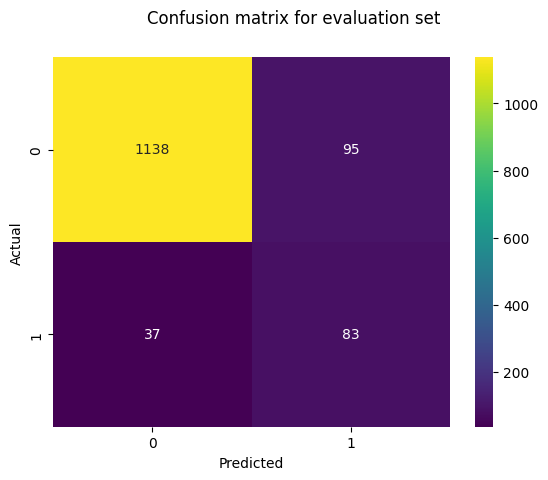

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred)
plt.suptitle('Confusion matrix for evaluation set')
ax=sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
plt.show()

In [25]:
precision,recall,f1,support=precision_recall_fscore_support(y_val,y_pred)
accuracy=accuracy_score(y_val,y_pred)
print("Precision: ", precision) 
print("Recall: ", recall)
print("F1 Score: ", f1)
print('Accuracy', accuracy)

Precision:  [0.96851064 0.46629213]
Recall:  [0.92295215 0.69166667]
F1 Score:  [0.94518272 0.55704698]
Accuracy 0.9024390243902439


In [26]:
precision,recall,f1,_=precision_recall_fscore_support(y_val,y_pred,average='weighted')
print("Precision: ", precision) 
print("Recall: ", recall)
print("F1 Score: ", f1)
total=sum(sum(cm))
accuracy=(cm[0,0]+cm[1,1])/total
print ('Accuracy Test : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity)

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity)

Precision:  0.9239679772365499
Recall:  0.9024390243902439
F1 Score:  0.9107582679875941
Accuracy Test :  0.9024390243902439
Sensitivity :  0.9229521492295215
Specificity :  0.6916666666666667


Text(0.5, 1.0, 'Top 15 Importance Important Features')

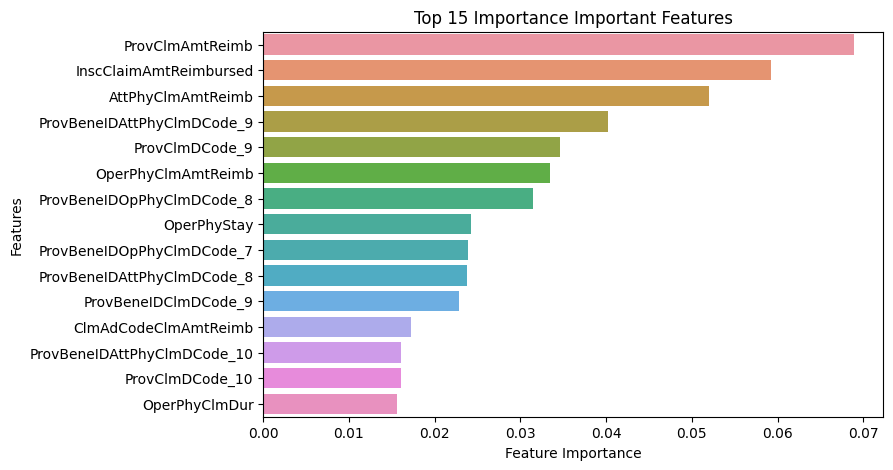

In [27]:
df=train.drop(['PotentialFraud','Provider'], axis=1)
feats_imps = pd.DataFrame({'Features': df.columns, 'Importance_Model_1': model.feature_importances_})
feats_imps = feats_imps[feats_imps['Importance_Model_1'] != 0]
feats_imps.reset_index(drop=True, inplace=True)

top_15 = feats_imps.sort_values(by='Importance_Model_1',axis=0,ascending=False).iloc[:15,:]
fig,ax=plt.subplots(1,1,figsize=(8,5))
sns.barplot(x='Importance_Model_1',y='Features',data=top_15,orient='h')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 15 Importance Important Features")

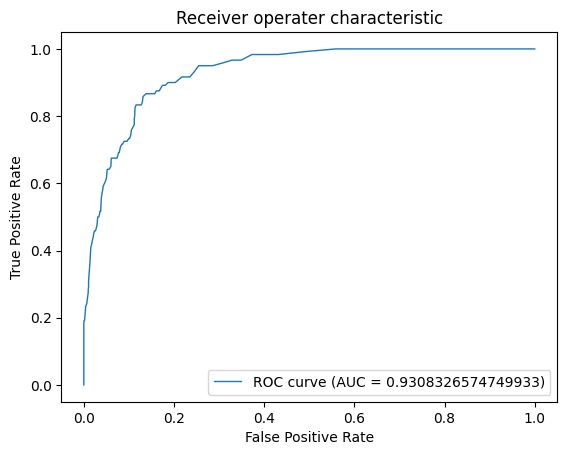

In [28]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,thresholds=roc_curve(y_val, model.predict_proba(x_val)[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr,tpr,lw=1,label=f'ROC curve (AUC = {roc_auc})')
        
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operater characteristic')
plt.legend()
plt.show()

In [29]:
Y_test=model.predict(X_test)
pred=pd.DataFrame({'Predictions':Y_test})
pred.value_counts()

Predictions
0              1187
1               166
Name: count, dtype: int64

In [36]:
submit_df=pd.DataFrame({'Provider':test['Provider'],'Predictions':Y_test})
submit_df.to_csv('final_submission.csv')